In [1]:
using FEM, Potential, PyPlot, Printf, JLD, Dierckx

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 0.5 # unit: angstrom
xavg = 0   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$

In [ ]:
# S_eq = -1.683 # symmetry_wall_potential.(-0.5, 0.5, 0.06, 2.4e9, xref)

In [99]:
Vref = symmetry_wall_potential.(-0.5, 0.5, 0.01, 2.4e9, xref)
Veq_spl = Spline1D(xref[:,1], Vref[:,1])
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq
s_eq = -sum(w0 .* p_eq .* log.(p_eq))

-0.15168721884141875

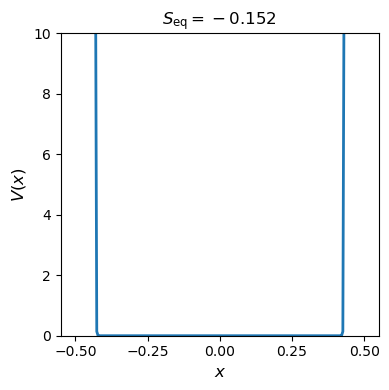

In [100]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

ax.plot(xref, Vref, linewidth=2)
#ax.plot(xref, Veq_spl(xref[:,1]))
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-0.5:0.25:0.5)
ax.set_ylim(0, 10)
ax.set_title(@sprintf "\$S_{\\rm eq}=%.3f\$" s_eq)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/flat_potential_5.svg")
plt.show()

### Part 3: Set $p_{\rm eq}(x)$

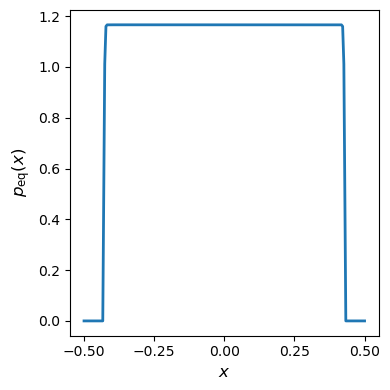

In [101]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-0.5:0.25:0.5)

plt.tight_layout()
#plt.savefig("symmetry_wall_phi.pdf")
plt.show()

#### Trajectory entropy

In [83]:
-sum(w0 .* p_eq .* log.(p_eq))

-0.2339582965892353

### Part 4: Langenvin dynamics simulations

In [109]:
# physical parameters
save_freq = 1e-3 # unit: s, Save trajectory per 10e-3 s
total_times = 10 # unit: s, totol simulate 10 s
dt = 1e-5 # unit: s  # Integration Times 1ps
D = 1; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 2000 timesteps. There will be 10000 data points.


In [110]:
# Initialize Variables
y_record = zeros(tau+1, 1)  # In HMM, observing variables Y(t)
t_record = zeros(tau+1, 1)

ypos = xavg # Initial Position, from mean position
t = 0

# Simulation Start
for tau_id = 1:tau
    y_record[tau_id] = ypos
    t_record[tau_id] = t
    for i = 1:n_interval
        F = -derivative(Veq_spl, ypos)
        ypos = ypos + D*dt*F + (dt*2*D)^(1/2) * randn()
        t += dt   
    end
end
y_record[tau+1] = ypos
t_record[tau+1] = t;

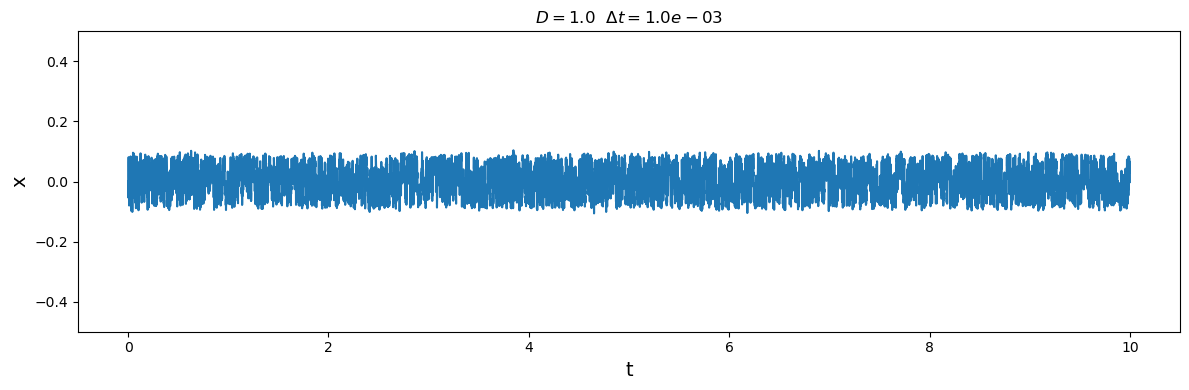

In [125]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x", fontsize=lbfz)
ax.set_xlabel("t", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f~~\\Delta t=%.1e\$" D save_freq)
ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/flat_traj_0.svg")
plt.show()

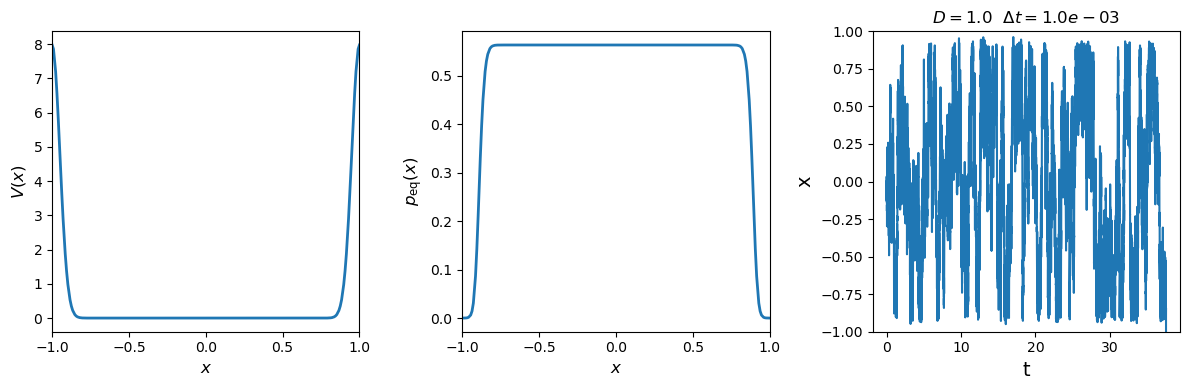

In [72]:
lbfz = 14
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
#ax.plot(xref, Veq_spl(xref[:,1]))
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xlim(-1, 1)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xlim(-1, 1)

ax = axes[3]
ax.plot(t_record, y_record)
ax.set_ylabel("x", fontsize=lbfz)
ax.set_xlabel("t", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f~~\\Delta t=%.1e\$" D save_freq)
ax.set_ylim(-1, 1)

plt.tight_layout()
#plt.savefig("V_flat_potential_dimensionless_0.png", dpi=150)
plt.show()

### Part 4: Save trajectory or Read trajectory

In [113]:
# Save simulated trajectory to jld file
f_out = "/home/yizaochen/codes/julia/md_pisl/trajectory/flat_potential_5.jld"
save(f_out, "y_record", y_record, "t_record", t_record, "xref", xref, "rho_eq", rho_eq, "D", D)

In [124]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/flat_potential_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
D = load(f_in, "D");